In [1]:
import uproot
import pandas
import numpy as np
import itertools 
import matplotlib.pyplot as plt
# from pylorentz import Momentum4
from lvec import LVec
import cvae_tools as nt
import data_utils as du
import glob
import torch
import torch.nn as nn
import pandas as pd
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

infile_raw = uproot.open("raw_data/B2Dstmu_11574021_trueTuple.root")["DTTDstmu/MCDecayTree;1"].arrays(library='pd')

In [2]:
B_momentum = np.array([infile_raw['B0_TRUEP_E'], infile_raw['B0_TRUEP_X'], infile_raw['B0_TRUEP_Y'], infile_raw['B0_TRUEP_Z']]).T
Dstar_momentum = np.array([infile_raw['Dst_2010_minus_TRUEP_E'], infile_raw['Dst_2010_minus_TRUEP_X'], infile_raw['Dst_2010_minus_TRUEP_Y'], infile_raw['Dst_2010_minus_TRUEP_Z']]).T
mu_momentum = np.array([infile_raw['muplus_TRUEP_E'], infile_raw['muplus_TRUEP_X'], infile_raw['muplus_TRUEP_Y'], infile_raw['muplus_TRUEP_Z']]).T
neutrino_momentum = B_momentum - Dstar_momentum - mu_momentum
D0_momentum = np.array([infile_raw['D~0_TRUEP_E'], infile_raw['D~0_TRUEP_X'], infile_raw['D~0_TRUEP_Y'], infile_raw['D~0_TRUEP_Z']]).T
slpi_momentum = np.array([infile_raw['piminus0_TRUEP_E'], infile_raw['piminus0_TRUEP_X'], infile_raw['piminus0_TRUEP_Y'], infile_raw['piminus0_TRUEP_Z']]).T

W_momentum = B_momentum - Dstar_momentum

In [3]:
def lorentz_boost_lvec(mom1, mom2, valid_mask=None):
    if valid_mask is None:
        valid_mask = np.ones(mom1.shape[0], dtype=bool)  

    valid_mom1, valid_mom2 = mom1[valid_mask], mom2[valid_mask]


    p1x, p1y, p1z, E1 = valid_mom1[:, 1], valid_mom1[:, 2], valid_mom1[:, 3], valid_mom1[:, 0]
    p2x, p2y, p2z, E2 = valid_mom2[:, 1], valid_mom2[:, 2], valid_mom2[:, 3], valid_mom2[:, 0]

    mom1_valid = LVec(p1x, p1y, p1z, E1)

    b2_x, b2_y, b2_z = -p2x / E2, -p2y / E2, -p2z / E2

    mom1_boosted = mom1_valid.boost(b2_x, b2_y, b2_z)

    return np.column_stack((mom1_boosted.E, mom1_boosted.px, mom1_boosted.py, mom1_boosted.pz))

def valid_configs(b1,b2,b3):
    beta_sq = b1**2 + b2**2 + b3**2
    valid_mask = beta_sq <= 1

    return valid_mask

def dot(vec1, vec2):
    return np.einsum('ij,ij->i', vec1, vec2)  # Element-wise dot product for each pair of vectors

def cross(vec1, vec2):
    return np.cross(vec1, vec2)  # Element-wise cross product for each pair of vectors


def signed_angle(a, b):
    # Compute the dot product of vectors a and b
    dot_product = np.einsum('ij,ij->i', a, b)

    # Compute the norms of a and b
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)

    # Compute the cosine of the angle between a and b
    cos_angle = dot_product / (norm_a * norm_b)

    # Clip cos_angle to handle any floating-point precision issues
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    # Compute the angle in radians using arccos
    angle = np.arccos(cos_angle)

    # Compute the cross product to determine the sign of the angle
    cross_product = np.cross(a, b)

    # Compute the sign of the cross product along the third axis
    sign = np.sign(cross_product[:, 2])

    # Adjust angle to be between 0 and 2π
    angle = np.where(sign >= 0, angle, 2 * np.pi - angle)

    return angle

def invariant_mass_squared(p):
    M2 = []
    for i in range(len(p)):
        M2.append(p[i][0]**2 - p[i][1]**2 - p[i][2]**2 - p[i][3]**2)
    M2 = np.array(M2)
    return M2

In [4]:
B_reco = np.array([infile_raw['B0_TRUEP_E'], infile_raw['B0_TRUEP_X'], infile_raw['B0_TRUEP_Y'], infile_raw['B0_TRUEP_Z']]).T
Dstar_reco = np.array([infile_raw['Dst_2010_minus_TRUEP_E'], infile_raw['Dst_2010_minus_TRUEP_X'], infile_raw['Dst_2010_minus_TRUEP_Y'], infile_raw['Dst_2010_minus_TRUEP_Z']]).T
mu_reco = np.array([infile_raw['muplus_TRUEP_E'], infile_raw['muplus_TRUEP_X'], infile_raw['muplus_TRUEP_Y'], infile_raw['muplus_TRUEP_Z']]).T
nu_reco = B_reco - Dstar_reco - mu_reco
W_reco = B_reco - Dstar_reco
mom1 = mu_reco
mom2 = W_reco
mom3 = nu_reco
mom4 = B_reco

p1x, p1y, p1z, E1 = mom1.T[1], mom1.T[2], mom1.T[3], mom1.T[0]
p2x, p2y, p2z, E2 = mom2.T[1], mom2.T[2], mom2.T[3], mom2.T[0]
p3x, p3y, p3z, E3 = mom3.T[1], mom3.T[2], mom3.T[3], mom3.T[0]
p4x, p4y, p4z, E4 = mom4.T[1], mom4.T[2], mom4.T[3], mom4.T[0]

mom2 = LVec(p2x, p2y, p2z, E2)
mom4 = LVec(p4x, p4y, p4z, E4)

b2_x, b2_y, b2_z = -p2x/E2, -p2y/E2, -p2z/E2
b4_x, b4_y, b4_z = -p4x/E4, -p4y/E4, -p4z/E4

valid_indices = valid_configs(b2_x, b2_y, b2_z)
valid_energy_mask = nu_reco.T[0] >= 0
valid_energy_list = (valid_energy_mask)
future_energy = E3 + (p3x * b4_x + p3y * b4_y + p3z * b4_z)
valid_future_energy_mask = future_energy >= 0

final_valid_mask = ~(~valid_indices | ~valid_energy_mask | ~valid_future_energy_mask)

valid_indices = final_valid_mask

proportion_false = np.mean(~valid_indices)
print(f"Number of configurations: {len(valid_indices)}")
print(f"Proportion of invalid configurations: {proportion_false:.2%}")
print(f"Number of invalid configurations: {np.sum(~valid_indices)}")


Number of configurations: 100394
Proportion of invalid configurations: 0.00%
Number of invalid configurations: 0


In [7]:
#q-squared calculation
q2 = invariant_mass_squared(W_momentum)/1e6
q2 = q2[valid_indices]

# CosTheta_L Calculation
mu_W_boosted = lorentz_boost_lvec(mu_momentum, W_momentum,valid_indices)
mu_W_boosted_p = mu_W_boosted[:,1:]
W_p = W_momentum[:,1:]

B_W_boosted = lorentz_boost_lvec(B_momentum, W_momentum, valid_indices)
B_W_boosted_p = B_W_boosted[:,1:]

z_axis = B_W_boosted_p / np.linalg.norm(B_W_boosted_p, axis=1, keepdims=True)

cos_theta_l = dot(mu_W_boosted_p,z_axis)/np.sqrt(dot(mu_W_boosted_p,mu_W_boosted_p))

# CosTheta_D Calculation
D0_Dstar_boosted = lorentz_boost_lvec(D0_momentum, Dstar_momentum, valid_indices)
D0_Dstar_boosted_p = D0_Dstar_boosted[:,1:]

B_Dstar_boosted = lorentz_boost_lvec(B_momentum, Dstar_momentum, valid_indices)
B_Dstar_boosted_p = B_Dstar_boosted[:,1:]
z_axis = B_Dstar_boosted_p / np.linalg.norm(B_Dstar_boosted_p, axis=1, keepdims=True)

cos_theta_d = dot(D0_Dstar_boosted_p,z_axis)/np.sqrt(dot(D0_Dstar_boosted_p,D0_Dstar_boosted_p))

# Phi Calculation
mu_B_boosted = lorentz_boost_lvec(mu_momentum, B_momentum, valid_indices)
mu_B_boosted_p = mu_B_boosted[:,1:]

neutrino_B_boosted = lorentz_boost_lvec(neutrino_momentum, B_momentum, valid_indices)
neutrino_B_boosted_p = neutrino_B_boosted[:,1:]

D0_B_boosted = lorentz_boost_lvec(D0_momentum, B_momentum, valid_indices)
D0_B_boosted_p = D0_B_boosted[:,1:]

slpi_B_boosted = lorentz_boost_lvec(slpi_momentum, B_momentum, valid_indices)
slpi_B_boosted_p = slpi_B_boosted[:,1:]

mu_neutrino_plane = cross(mu_B_boosted_p,neutrino_B_boosted_p)
D0_slpi_plane = cross(D0_B_boosted_p,slpi_B_boosted_p)

phi = signed_angle(mu_neutrino_plane, D0_slpi_plane)

obs_matrix = np.array([q2, cos_theta_l, cos_theta_d, phi])

(array([ 8713., 10609., 11584., 10619.,  8764.,  8599., 10606., 11425.,
        10630.,  8845.]),
 array([4.17996350e-05, 6.28351078e-01, 1.25666036e+00, 1.88496963e+00,
        2.51327891e+00, 3.14158819e+00, 3.76989747e+00, 4.39820675e+00,
        5.02651602e+00, 5.65482530e+00, 6.28313458e+00]),
 <BarContainer object of 10 artists>)

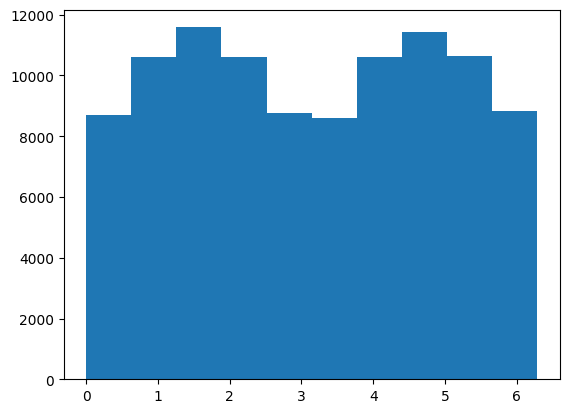

In [10]:
plt.hist(phi, bins=10)

In [6]:
normal_path = 'nn_outputs/wilson_mu_csr_cvr'

number_of_files = len(glob.glob(normal_path + '/normal_targets/*.csv'))

train_amount = int(0.7 * number_of_files)
val_amount = int(0.15 * number_of_files)

train_inputs, train_targets, val_test_inputs, val_test_targets, file_names = du.load_minmax_heights(normal_path, train_amount)

# =-=-=-= Splitting the remaining data into validation and testing datasets =-=-=-=
val_inputs, val_targets = val_test_inputs[:val_amount], val_test_targets[:val_amount]

test_inputs, test_targets = val_test_inputs[val_amount:], val_test_targets[val_amount:]

# =-=-=-= Load in the Bayesian Optimised Hyperparmaeters into a Dictionary =-=-=-=
cfg = nt.BO_CVAE(normal_path, train_inputs, train_targets)

CSV Files: Bin Heights Already Normalised.


In [44]:
DEVICE = torch.device('cpu')

fixed_inputs = torch.Tensor([0.5, 0.5]).to(DEVICE)

csr_model_gen = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                            encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                            dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

csr_model_gen.load_state_dict(torch.load('nn_outputs/wilson_mu_csr_cvr/CVAE_mu_4d.pth', weights_only=False))
csr_model_gen.to(DEVICE)

eos_ref = pd.read_csv('nn_outputs/wilson_mu_csr_cvr/normal_targets/model_WET_mu_1746.csv')

sample = csr_model_gen.generate_histogram(fixed_inputs)

outputs = sample.to('cpu', dtype=torch.float64)

# Bin the Full Course No Selection Data
hist, edges = np.histogramdd(obs_matrix.T, bins=10)
bin_centers = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(4)]
xpos, ypos, zpos, wpos = np.meshgrid(*bin_centers, indexing="ij")

# Construct DFs for calculate obs and NN outputs
result_sim = pd.DataFrame({
            'q2': xpos.ravel(),
            'cos_theta_l': ypos.ravel(),
            'cos_theta_d': zpos.ravel(),
            'phi': wpos.ravel(),
            'bin_height': hist.ravel()
        })

result_df = pd.DataFrame({
        'q2':  xpos.ravel(),
        'cos_theta_l': ypos.ravel(),
        'cos_theta_d': zpos.ravel(),
        'phi': wpos.ravel(),
        'bin_height': outputs.ravel()
    })


In [45]:
def normalize_distributions_with_bins(*dataframes):
    """
    Normalizes the 'bin_height' column of each DataFrame such that the area under the curve is 1,
    considering the bin widths defined by the respective columns.

    Parameters:
        *dataframes: Variable number of pandas DataFrames, each containing a 'bin_height' column
                     and a column defining the bin edges (e.g., 'q2', 'cos_theta_l', etc.).

    Returns:
        A list of normalized DataFrames.
    """
    normalized_dfs = []
    for df in dataframes:
        # Identify the bin column (assumes it's the first column in the DataFrame)
        bin_column = df.columns[0]
        
        # Calculate bin widths
        bin_edges = df[bin_column].values
        bin_widths = np.diff(bin_edges)[-1]
        
        # Calculate the total area
        total_area = (df['bin_height'] * bin_widths).sum()
        
        # Normalize bin heights
        if total_area > 0:
            df['bin_height'] = df['bin_height'] / total_area
        
        normalized_dfs.append(df)

    return normalized_dfs

In [46]:
q2_ne =  result_df.groupby(['q2'])["bin_height"].sum().reset_index()
cos_l_ne =  result_df.groupby(['cos_theta_l'])["bin_height"].sum().reset_index()
cos_d_ne =  result_df.groupby(['cos_theta_d'])["bin_height"].sum().reset_index()
phi_ne =  result_df.groupby(['phi'])["bin_height"].sum().reset_index()

err_q2 = np.sqrt(q2_ne['bin_height'].values)
err_cos_l = np.sqrt(cos_l_ne['bin_height'].values)
err_cos_d = np.sqrt(cos_d_ne['bin_height'].values)
err_phi = np.sqrt(phi_ne['bin_height'].values)

perc_err_q2 = err_q2 / q2_ne['bin_height'].values
perc_err_cos_l = err_cos_l / cos_l_ne['bin_height'].values
perc_err_cos_d = err_cos_d / cos_d_ne['bin_height'].values
perc_err_phi= err_phi / phi_ne['bin_height'].values

q2_sim =  result_sim.groupby(['q2'])["bin_height"].sum().reset_index()
cos_l_sim =  result_sim.groupby(['cos_theta_l'])["bin_height"].sum().reset_index()
cos_d_sim =  result_sim.groupby(['cos_theta_d'])["bin_height"].sum().reset_index()
phi_sim =  result_sim.groupby(['phi'])["bin_height"].sum().reset_index()

q2_ne, cos_l_ne, cos_d_ne, phi_ne = normalize_distributions_with_bins(q2_ne, cos_l_ne, cos_d_ne, phi_ne)
q2_sim, cos_l_sim, cos_d_sim, phi_sim = normalize_distributions_with_bins(q2_sim, cos_l_sim, cos_d_sim, phi_sim)

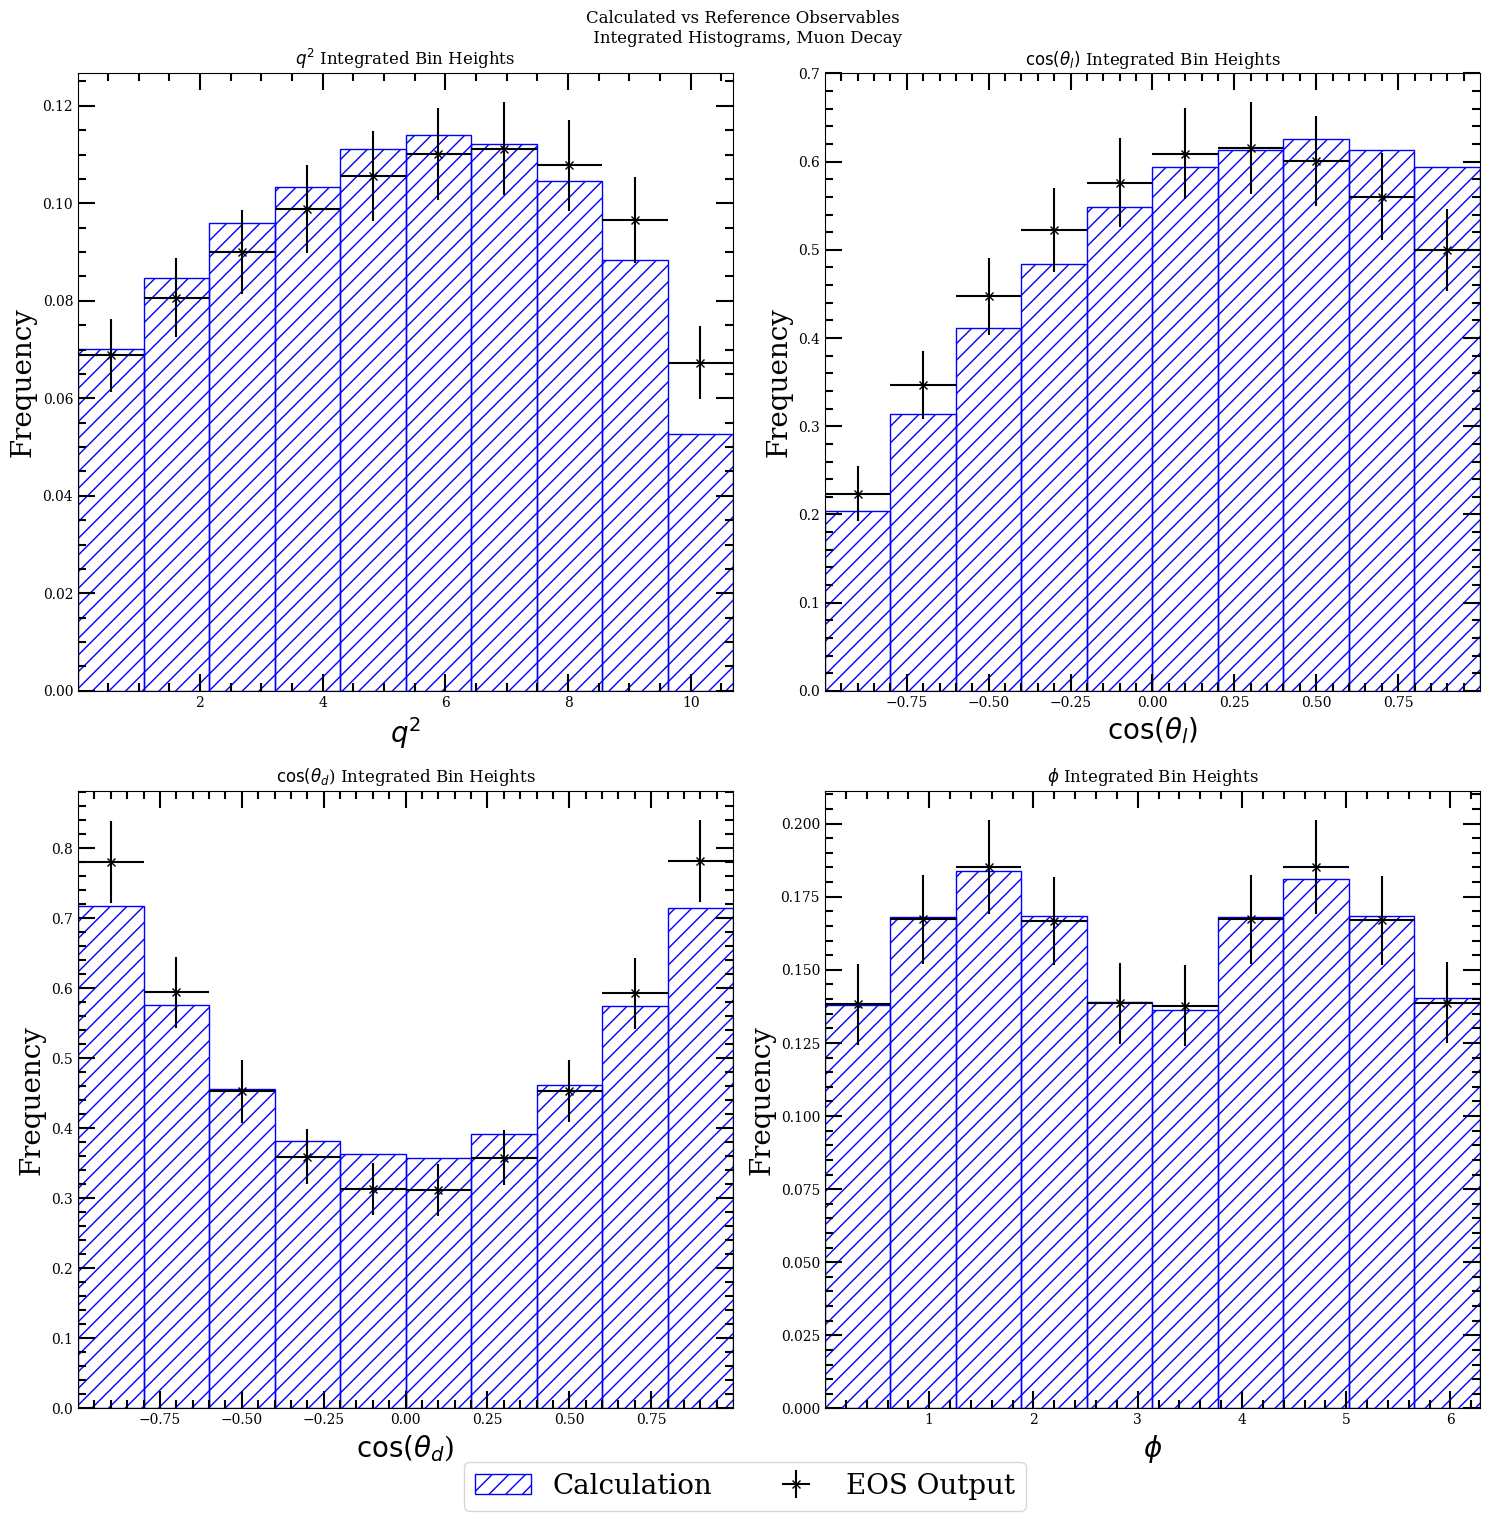

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

ne_data = [
    (np.unique(q2_ne['q2'].values), q2_ne['bin_height']),
    (np.unique(cos_l_ne['cos_theta_l'].values), cos_l_ne['bin_height']),
    (np.unique(cos_d_ne['cos_theta_d'].values), cos_d_ne['bin_height']),
    (np.unique(phi_ne['phi'].values), phi_ne['bin_height'])
]

sim_vals = [(np.unique(q2_sim['q2'].values), q2_sim['bin_height']),
            (np.unique(cos_l_sim['cos_theta_l'].values), cos_l_sim['bin_height']),
            (np.unique(cos_d_sim['cos_theta_d'].values), cos_d_sim['bin_height']),
            (np.unique(phi_sim['phi'].values), phi_sim['bin_height'])]

errors = [perc_err_q2, perc_err_cos_l, perc_err_cos_d, perc_err_phi]

titles = [r'$q^2$', r'$\cos(\theta_l)$', r'$\cos(\theta_d$)', r'$\phi$']

plt.rcParams['font.family'] = 'Serif'

ps = []

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, ax in enumerate(axs):
    # Plot _sim data as bars
    # eos_centers = nn_data[i][0]
    nn_centers = ne_data[i][0]

    w = np.diff(sim_vals[i][0])[-1]

    if i == 1:
        ax.bar(x=sim_vals[i][0], height=sim_vals[i][1].values[::-1],  width=w, color='none', hatch='//', edgecolor='blue', label='Calculation')
    
    else:
        ax.bar(x=sim_vals[i][0], height=sim_vals[i][1].values,  width=w, color='none', hatch='//', edgecolor='blue', label='Calculation')
    
    # Plot _nn data as dots with error bars

    ne_heights= ne_data[i][1]
    resc = np.sum(sim_vals[i][1]) / np.sum(ne_heights)

    ne_heights = ne_heights * resc
    err_bars = errors[i] * ne_heights

    ax.errorbar(sim_vals[i][0], ne_heights, fmt='x', xerr=w/2, yerr=err_bars, color='black', label='EOS Output')

    # chi2_stat, p_value = chisquare(f_obs=sim_vals[i][1], f_exp=ne_heights)
    # ps.append(p_value)
    
    # Set title and labels
    ax.set_title(f'{titles[i]} Integrated Bin Heights')
    ax.set_xlabel(f'{titles[i]}', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20) 
    # ax.legend()

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    ax.tick_params(
            axis='both',
            which='major',
            direction='in',
            right = True,
            top = True,
            length=12,
            width=1.5,
        )

        # Minor ticks: smaller and thinner
    ax.tick_params(
            axis='both',
            which='minor',
            direction='in',
            right = True,
            top = True,
            length=6,
            width=1.5,
        )
    
    ax.set_xlim((min(sim_vals[i][0]) - w, max(sim_vals[i][0])) + w/2)

fig.legend(
    handles=handles[:3],  # Ensure you pass the correct handles for the legend
    labels=labels[:3],    # Ensure you pass the correct labels for the legend
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.03),  # Centered at the bottom
    fontsize=20
)

fig.suptitle('Calculated vs Reference Observables \n Integrated Histograms, Muon Decay')

plt.tight_layout()

# Example usage:
# plot_distributions(q2_nn, cos_l_nn, cos_d_nn, phi_nn, q2_sim, cos_l_sim, cos_d_sim, phi)

## 3. Individualised Cells

Same calculations just separate for unit-wise testing/plotting.

In [ ]:
mu_W_boosted = lorentz_boost_lvec(mu_momentum, W_momentum,valid_indices)
mu_W_boosted_p = mu_W_boosted[:,1:]
W_p = W_momentum[:,1:]

# W_B_boosted = lorentz_boost_lvec(W_momentum, B_momentum, valid_indices)
# W_B_boosted_p = W_B_boosted[:,1:]

# z_axis = W_B_boosted_p / np.linalg.norm(W_B_boosted_p, axis=1, keepdims=True)

B_W_boosted = lorentz_boost_lvec(B_momentum, W_momentum, valid_indices)
B_W_boosted_p = B_W_boosted[:,1:]

z_axis = B_W_boosted_p / np.linalg.norm(B_W_boosted_p, axis=1, keepdims=True)

# D_star_B_boosted = lorentz_boost_lvec(Dstar_momentum, B_momentum, valid_indices)
# D_star_B_boosted_p = D_star_B_boosted[:,1:]

# z_axis = D_star_B_boosted_p / np.linalg.norm(D_star_B_boosted_p, axis=1, keepdims=True)

cos_theta_l = dot(mu_W_boosted_p,z_axis)/np.sqrt(dot(mu_W_boosted_p,mu_W_boosted_p))

In [ ]:
D0_Dstar_boosted = lorentz_boost_lvec(D0_momentum, Dstar_momentum, valid_indices)
D0_Dstar_boosted_p = D0_Dstar_boosted[:,1:]

B_Dstar_boosted = lorentz_boost_lvec(B_momentum, Dstar_momentum, valid_indices)
B_Dstar_boosted_p = B_Dstar_boosted[:,1:]
z_axis = B_Dstar_boosted_p / np.linalg.norm(B_Dstar_boosted_p, axis=1, keepdims=True)

# Dstar_B_boosted = lorentz_boost_lvec(Dstar_momentum, B_momentum)
# Dstar_B_boosted_p = Dstar_B_boosted[:,1:]
# z_axis = (Dstar_B_boosted_p.T/np.sqrt(dot(Dstar_B_boosted_p,Dstar_B_boosted_p))).T

cos_theta_d = dot(D0_Dstar_boosted_p,z_axis)/np.sqrt(dot(D0_Dstar_boosted_p,D0_Dstar_boosted_p))

In [ ]:
mu_B_boosted = lorentz_boost_lvec(mu_momentum, B_momentum, valid_indices)
mu_B_boosted_p = mu_B_boosted[:,1:]

neutrino_B_boosted = lorentz_boost_lvec(neutrino_momentum, B_momentum, valid_indices)
neutrino_B_boosted_p = neutrino_B_boosted[:,1:]

D0_B_boosted = lorentz_boost_lvec(D0_momentum, B_momentum, valid_indices)
D0_B_boosted_p = D0_B_boosted[:,1:]

slpi_B_boosted = lorentz_boost_lvec(slpi_momentum, B_momentum, valid_indices)
slpi_B_boosted_p = slpi_B_boosted[:,1:]

mu_neutrino_plane = cross(mu_B_boosted_p,neutrino_B_boosted_p)
D0_slpi_plane = cross(D0_B_boosted_p,slpi_B_boosted_p)

phi = signed_angle(mu_neutrino_plane, D0_slpi_plane)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Data and titles for the plots
data = [cos_theta_l, cos_theta_d, phi, q2]
titles = [r'$\cos\theta_l$', r'$\cos\theta_D$', r'$\phi$', r'$q^2$']

# Loop through the data and plot each one
for i, ax in enumerate(axs.flat):
    ax.hist(data[i], density = True)
    ax.set_title(titles[i], fontsize = 14)

plt.tight_layout()
fig.suptitle('Raw variables', fontsize=16, y=1.04)
plt.savefig('raw_fit_variables.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
raw_df = pandas.DataFrame({
    'cos_theta_l': cos_theta_l,
    'cos_theta_d': cos_theta_d,
    'phi': phi,
    'q2': q2,
})
raw_df.to_csv('raw_fit_variables.csv', index=False)